In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings
from tensorflow.keras.utils import plot_model
from keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D,BatchNormalization, Flatten, Dense, Dropout

In [ ]:
labels = ['glioma_tumor', 'no_tumor', 'meningioma_tumor', 'pituitary_tumor']

X_train = []
y_train = []
image_size = 150
for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/MRI BTD Classification dataset','Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)

for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/MRI BTD Classification dataset','Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)

X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 74/74 [00:33<00:00,  2.18it/s]


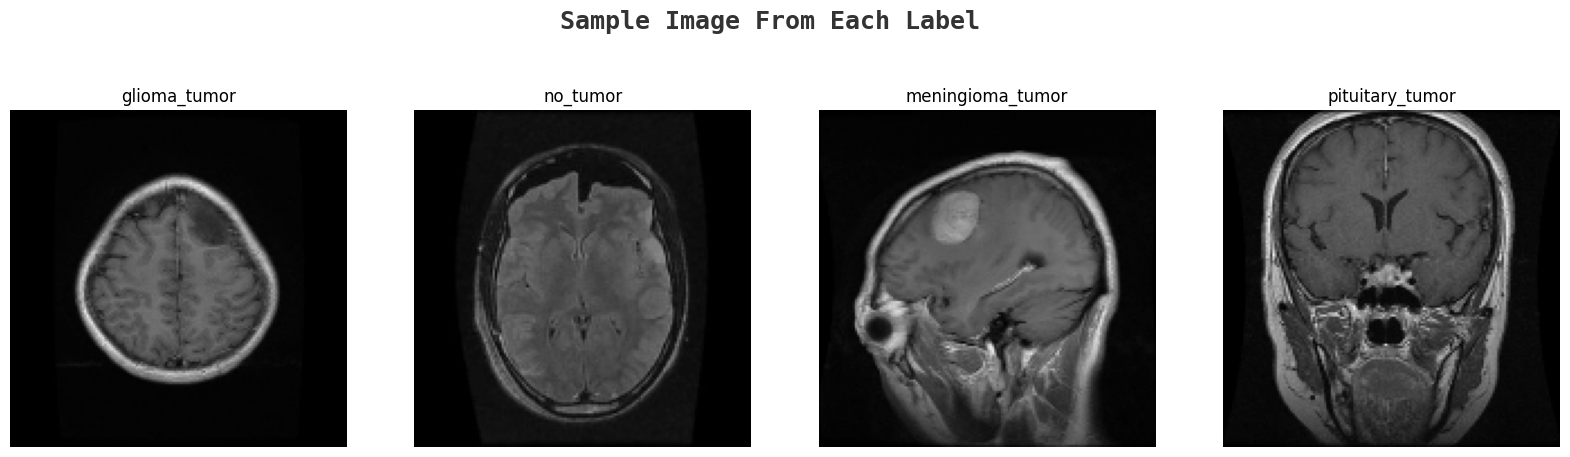

In [ ]:
k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1


In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=101)

In [ ]:
X_train.shape

(2946, 150, 150, 3)

In [ ]:
X_test.shape

(328, 150, 150, 3)

In [ ]:
y_train.shape

(2946,)

In [ ]:
y_test.shape

(328, 4)

In [ ]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [ ]:
y_test_labels = np.argmax(y_test, axis=1)

# Find unique class labels
unique_labels = np.unique(y_test_labels)

print("Unique class labels:", unique_labels)

Unique class labels: [0 1 2 3]


In [ ]:
effnet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

16705208/16705208 [==============================] - 1s 0us/step


In [ ]:
model = effnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=effnet.input, outputs = model)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 150, 150, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 150, 150, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, 150, 150, 3)          0         ['normalization[0][0]']   

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [ ]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("effnet.keras", monitor="val_accuracy", save_best_only=True, mode="auto", verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001, mode='auto',verbose=1)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.787384 to fit



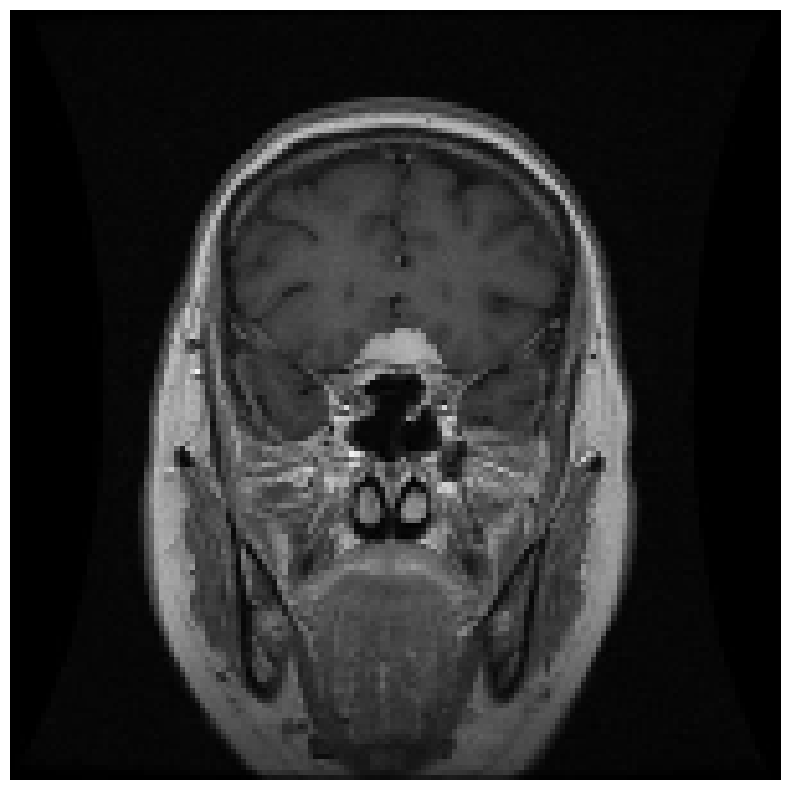

In [ ]:
plot_model(model, show_shapes=True, dpi=150)

# Display the plot
plt.figure(figsize=(20, 10))
plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
history = model.fit(X_train,y_train,validation_split=0.1, epochs =5, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/5
83/83 [==============================] - ETA: 0s - loss: 0.4460 - accuracy: 0.8336
Epoch 1: val_accuracy improved from -inf to 0.81695, saving model to effnet.keras
83/83 [==============================] - 71s 260ms/step - loss: 0.4460 - accuracy: 0.8336 - val_loss: 0.8325 - val_accuracy: 0.8169 - lr: 0.0010
Epoch 2/5
83/83 [==============================] - ETA: 0s - loss: 0.2032 - accuracy: 0.9347
Epoch 2: val_accuracy improved from 0.81695 to 0.92881, saving model to effnet.keras
83/83 [==============================] - 12s 142ms/step - loss: 0.2032 - accuracy: 0.9347 - val_loss: 0.2667 - val_accuracy: 0.9288 - lr: 0.0010
Epoch 3/5
83/83 [==============================] - ETA: 0s - loss: 0.1267 - accuracy: 0.9540
Epoch 3: val_accuracy improved from 0.92881 to 0.94237, saving model to effnet.keras
83/83 [==============================] - 12s 143ms/step - loss: 0.1267 - accuracy: 0.9540 - val_loss: 0.1597 - val_accuracy: 0.9424 - lr: 0.0010
Epoch 4/5
83/83 [=================

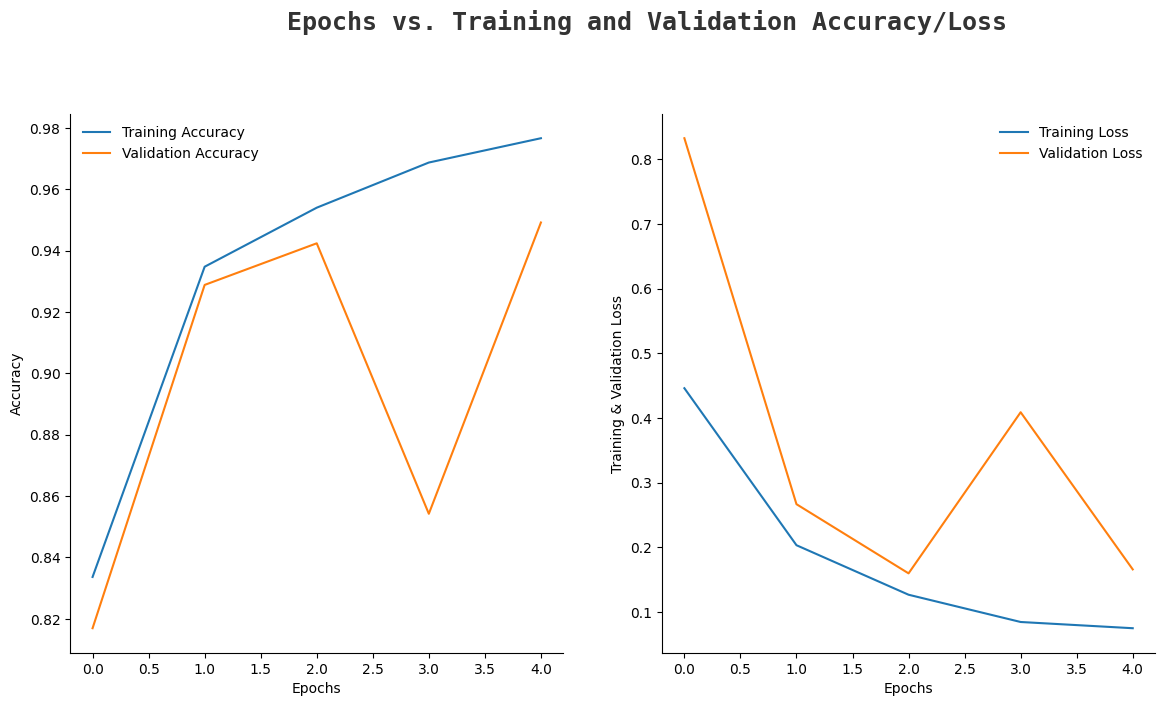

In [ ]:
filterwarnings('ignore')

epochs = [i for i in range(5)]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold', fontname='monospace',y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss,label ='Training Loss')
ax[1].plot(epochs, val_loss, label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()

In [ ]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

11/11 [==============================] - 3s 122ms/step


In [ ]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95        97
           1       0.96      1.00      0.98        51
           2       0.94      0.87      0.90        89
           3       0.93      0.96      0.94        91

    accuracy                           0.94       328
   macro avg       0.94      0.94      0.94       328
weighted avg       0.94      0.94      0.94       328



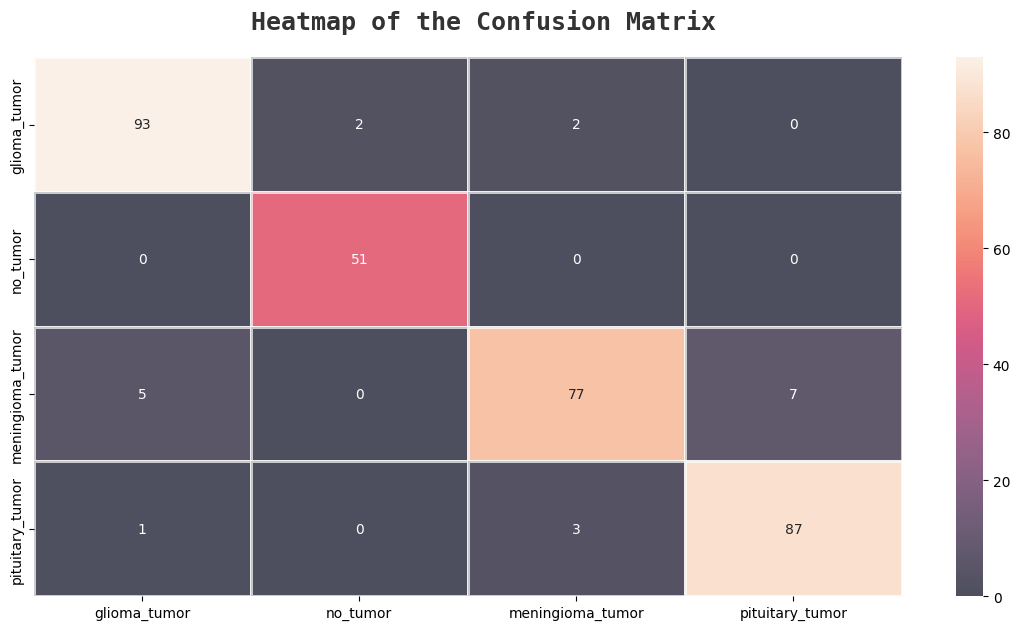

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True,alpha=0.7,linewidths=2)
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',y=0.92,x=0.28,alpha=0.8)

plt.show()

**Model**

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Flatten

model_lstm = Sequential()

# LSTM input shape: (time_steps, features)
# Adjust time_steps and features according to your data
time_steps = 224  # example value, adjust based on your sequence length
features = 3      # example value, adjust based on your number of features

# LSTM layer
model_lstm.add(LSTM(128, input_shape=(time_steps, features), return_sequences=True))
model_lstm.add(Dropout(0.2))

# LSTM layer
model_lstm.add(LSTM(64, return_sequences=False))
model_lstm.add(Dropout(0.2))

# Dense layers
model_lstm.add(Dense(128, activation='relu'))
model_lstm.add(Dense(64, activation='relu'))

# Output layer
model_lstm.add(Dense(4, activation='softmax'))  # Adjust output size as needed

# Compile model
model_lstm.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [5]:
model_lstm.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 224, 128)            │          67,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 224, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 133,828 (522.77 KB)

 Trainable params: 133,828 (522.77 KB)

 Non-trainable params: 0 (0.00 B)

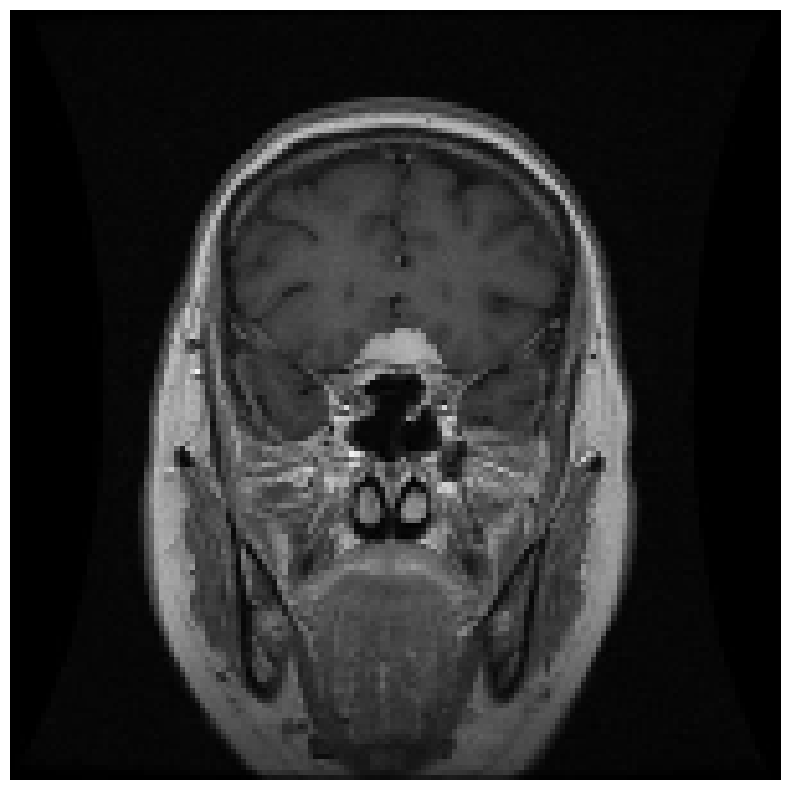

In [ ]:
plot_model(model_lstm, show_shapes=True, dpi=150)

# Display the plot
plt.figure(figsize=(20, 10))
plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
resized_X_train = []
for img in X_train:
    resized_img = cv2.resize(img, (224, 224))
    resized_X_train.append(resized_img)

resized_X_train = np.array(resized_X_train)

resized_X_test = []
for img in X_test:
    resized_img = cv2.resize(img, (224, 224))
    resized_X_test.append(resized_img)

resized_X_test = np.array(resized_X_test)

In [ ]:
model_lstm.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Input

# Define LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(128, input_shape=(224, 224, 3)))  # Adjust input_shape to match resized images
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(64, activation='relu'))
model_lstm.add(Dense(4, activation='softmax'))

# Compile LSTM model (no changes here)
model_lstm.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


model_lstm.summary()


Shape of extracted features: (10, 7, 7, 1280)


ValueError: Input 0 of layer "lstm_6" is incompatible with the layer: expected ndim=3, found ndim=4. Full shape received: (None, 224, 224, 3)

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Input, LSTM, Dropout, Dense, Reshape, Flatten

# Load EfficientNetB0 model without the top (classification) layers
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
base_model.trainable = False

# Function to preprocess images and extract features using EfficientNetB0
def preprocess_and_extract_features(images):
    # Resize images to match EfficientNetB0 input shape
    resized_images = tf.image.resize(images, (224, 224))
    # Preprocess input for EfficientNetB0
    processed_images = tf.keras.applications.efficientnet.preprocess_input(resized_images)
    # Extract features using the base model
    features = base_model(processed_images)
    return features

# Example of how to use the preprocessing function
sample_images = tf.convert_to_tensor(resized_X_train[:10], dtype=tf.float32)
sample_features = preprocess_and_extract_features(sample_images)
print("Shape of extracted features:", sample_features.shape)

# Define LSTM model
model_lstm = Sequential()
model_lstm.add(Reshape((224*224, 3), input_shape=(224, 224, 3)))  # Reshape to (timesteps, features)
model_lstm.add(LSTM(128))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(64, activation='relu'))
model_lstm.add(Dense(4, activation='softmax'))

# Compile LSTM model (no changes here)
model_lstm.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model_lstm.summary()

Shape of extracted features: (10, 7, 7, 1280)
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 50176, 3)          0         
                                                                 
 lstm_7 (LSTM)               (None, 128)               67584     
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_8 (Dense)             (None, 64)                8256      
                                                                 
 dense_9 (Dense)             (None, 4)                 260       
                                                                 
Total params: 76100 (297.27 KB)
Trainable params: 76100 (297.27 KB)
Non-trainable params: 0 (0.00 Byte)
____________________________________

In [ ]:
 # Import TimeDistributed

# ... (rest of the code)

# Define LSTM model
model_lstm = Sequential()
# Remove the reshape layer, process images with EfficientNetB0 first
# Assuming EfficientNetB0 output
# ... (rest of the model definition)

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Input, LSTM, Dropout, Dense, Reshape, Flatten, TimeDistributed

# Load EfficientNetB0 model without the top (classification) layers
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
base_model.trainable = False

# Function to preprocess images and extract features using EfficientNetB0
def preprocess_and_extract_features(images):
    # Resize images to match EfficientNetB0 input shape
    resized_images = tf.image.resize(images, (224, 224))
    # Preprocess input for EfficientNetB0
    processed_images = tf.keras.applications.efficientnet.preprocess_input(resized_images)
    # Extract features using the base model
    features = base_model(processed_images)
    return features

# Example of how to use the preprocessing function
sample_images = tf.convert_to_tensor(resized_X_train[:10], dtype=tf.float32)
sample_features = preprocess_and_extract_features(sample_images)
print("Shape of extracted features:", sample_features.shape)

# Define LSTM model
model_lstm = Sequential()
# Remove the reshape layer, process images with EfficientNetB0 first
model_lstm.add(TimeDistributed(Flatten(), input_shape=(None, 7, 7, 1280)))   # Assuming EfficientNetB0 output
model_lstm.add(LSTM(128))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(64, activation='relu'))
model_lstm.add(Dense(4, activation='softmax'))

# Compile LSTM model
model_lstm.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model_lstm.summary()

Shape of extracted features: (10, 7, 7, 1280)
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, None, 62720)       0         
 ributed)                                                        
                                                                 
 lstm_8 (LSTM)               (None, 128)               32178688  
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_10 (Dense)            (None, 64)                8256      
                                                                 
 dense_11 (Dense)            (None, 4)                 260       
                                                                 
Total params: 32187204 (122.78 MB)
Trainable params: 32187204 (122.78 MB)


In [ ]:
history = model_lstm.fit(resized_X_train,y_train,validation_split=0.1, epochs =10, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/10


ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_9" is incompatible with the layer: expected shape=(None, None, 7, 7, 1280), found shape=(None, 224, 224, 3)


In [ ]:
!pip install efficientnet

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, TimeDistributed, Flatten
import tensorflow as tf
from efficientnet.tfkeras import EfficientNetB0  # Now you can import it

# ... rest of your code ...

In [ ]:
!pip install efficientnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.0 MB/s eta 0:00:00


In [ ]:


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, TimeDistributed, Flatten
import tensorflow as tf
from efficientnet.tfkeras import EfficientNetB0

# Assuming resized_X_train has shape (batch_size, height, width, channels)

# Load EfficientNetB0 model without the top (classification) layers
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

# Function to preprocess images and extract features using EfficientNetB0
def preprocess_and_extract_features(images):
    resized_images = tf.image.resize(images, (224, 224))
    processed_images = tf.keras.applications.efficientnet.preprocess_input(resized_images)
    features = base_model(processed_images)
    return features

# Example of how to use the preprocessing function
sample_images = tf.convert_to_tensor(resized_X_train[:10], dtype=tf.float32)
sample_features = preprocess_and_extract_features(sample_images)

# Reshape features to match LSTM input shape
sample_features_shape = sample_features.shape
num_samples = sample_features_shape[0]
time_steps = 1  # You might want to increase this if using multiple time steps
reshape_features = tf.reshape(sample_features, (num_samples, time_steps, 7, 7, 1280))

# Define LSTM model
model_lstm = Sequential()
model_lstm.add(TimeDistributed(Flatten(), input_shape=(time_steps, 7, 7, 1280)))
model_lstm.add(LSTM(128))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(64, activation='relu'))
model_lstm.add(Dense(4, activation='softmax'))

# Compile LSTM model
model_lstm.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model_lstm.summary()



16804768/16804768 [==============================] - 7s 0us/step
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_1 (TimeDi  (None, 1, 62720)          0         
 stributed)                                                      
                                                                 
 lstm_9 (LSTM)               (None, 128)               32178688  
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_12 (Dense)            (None, 64)                8256      
                                                                 
 dense_13 (Dense)            (None, 4)                 260       
                                                                 
Total params: 32187204 (122.78 MB)
Trainable params: 3

In [ ]:
# Train the model with reshaped labels
history = model_lstm.fit(
    reshape_features,
    y_train[:reshape_features.shape[0]].reshape(-1, 1),  # Reshape labels to (num_samples, 1)
    validation_split=0.1,
    epochs=10,
    verbose=1,
    batch_size=32
)

Epoch 1/10
1/1 [==============================] - 0s 466ms/step - loss: 0.3938 - accuracy: 1.0000 - val_loss: 0.4738 - val_accuracy: 1.0000
Epoch 2/10
1/1 [==============================] - 0s 181ms/step - loss: 0.4638 - accuracy: 0.8889 - val_loss: 0.4753 - val_accuracy: 1.0000
Epoch 3/10
1/1 [==============================] - 0s 166ms/step - loss: 0.4620 - accuracy: 0.8889 - val_loss: 0.4751 - val_accuracy: 1.0000
Epoch 4/10
1/1 [==============================] - 0s 69ms/step - loss: 0.4969 - accuracy: 1.0000 - val_loss: 0.4780 - val_accuracy: 1.0000
Epoch 5/10
1/1 [==============================] - 0s 81ms/step - loss: 0.4204 - accuracy: 1.0000 - val_loss: 0.4795 - val_accuracy: 1.0000
Epoch 6/10
1/1 [==============================] - 0s 66ms/step - loss: 0.3777 - accuracy: 1.0000 - val_loss: 0.4804 - val_accuracy: 1.0000
Epoch 7/10
1/1 [==============================] - 0s 65ms/step - loss: 0.4433 - accuracy: 1.0000 - val_loss: 0.4751 - val_accuracy: 1.0000
Epoch 8/10
1/1 [========

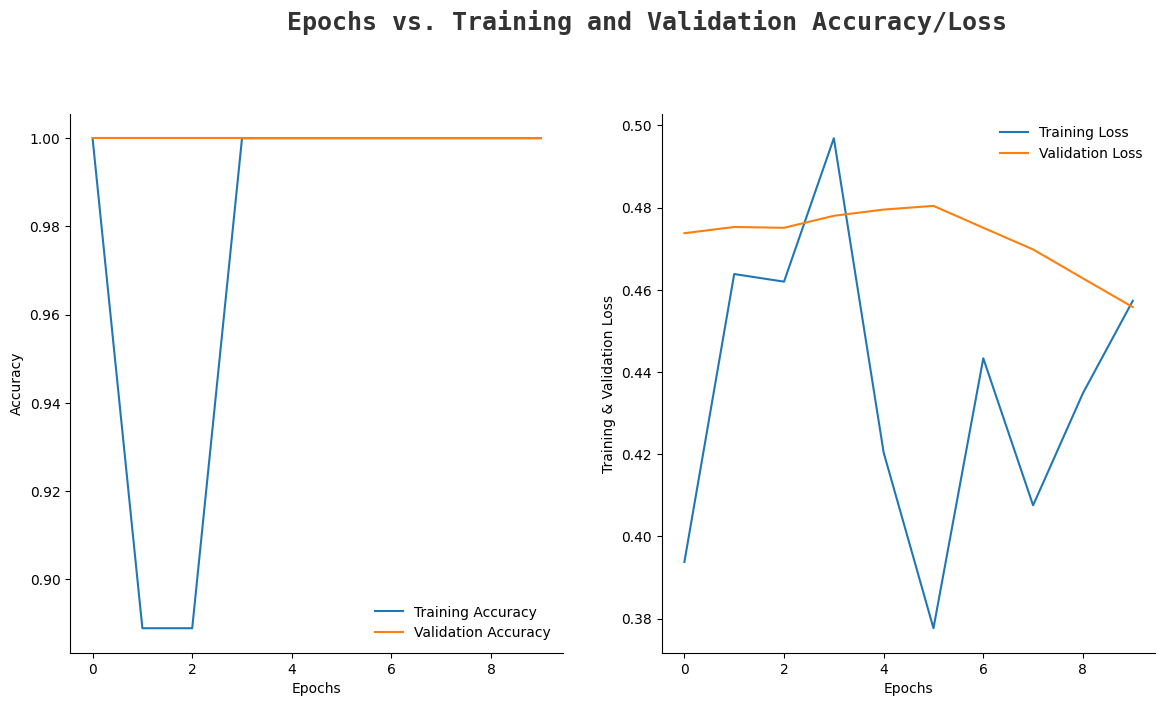

In [ ]:
filterwarnings('ignore')

epochs = [i for i in range(10)]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold', fontname='monospace',y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss,label ='Training Loss')
ax[1].plot(epochs, val_loss, label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()

In [ ]:
# Preprocess the test data
test_features = preprocess_and_extract_features(tf.convert_to_tensor(resized_X_test, dtype=tf.float32))

# Reshape test features to match LSTM input shape
test_features_shape = test_features.shape
num_test_samples = test_features_shape[0]
test_features_reshaped = tf.reshape(test_features, (num_test_samples, 1, 7, 7, 1280)) # Assuming time_steps = 1

# Now predict using the preprocessed and reshaped test data
pred = model_lstm.predict(test_features_reshaped)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

11/11 [==============================] - 1s 14ms/step


In [ ]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.30      1.00      0.46        97
           1       0.00      0.00      0.00        51
           2       0.00      0.00      0.00        89
           3       0.00      0.00      0.00        91

    accuracy                           0.30       328
   macro avg       0.07      0.25      0.11       328
weighted avg       0.09      0.30      0.13       328



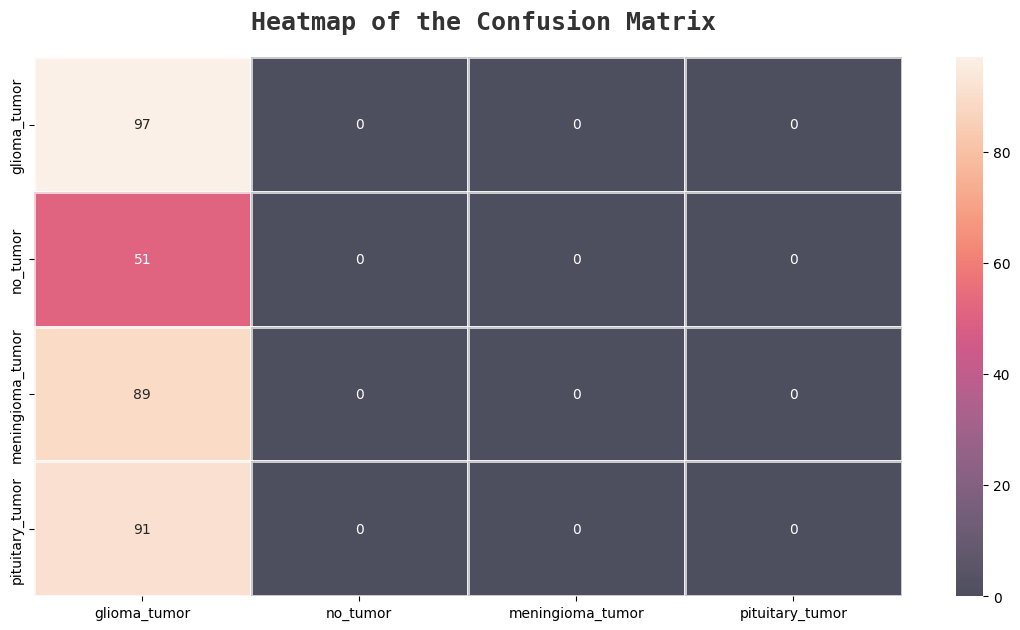

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True,alpha=0.7,linewidths=2)
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',y=0.92,x=0.28,alpha=0.8)

plt.show()

In [ ]:
model.save("/content/drive/MyDrive/MRI_Model_Saved/brain_LSTM.h5")